# Occupancy Prediction With Different Models Goated

First, let's inspect our database

In [1]:
import pandas as pd
import datetime

In [2]:
df = pd.read_csv("./data/dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35717 entries, 0 to 35716
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SystemCodeNumber  35717 non-null  object
 1   Capacity          35717 non-null  int64 
 2   Occupancy         35717 non-null  int64 
 3   LastUpdated       35717 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


Make LastUpdated column as type datetime64 instead of int64

In [3]:
df.LastUpdated = df.LastUpdated.astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35717 entries, 0 to 35716
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SystemCodeNumber  35717 non-null  object        
 1   Capacity          35717 non-null  int64         
 2   Occupancy         35717 non-null  int64         
 3   LastUpdated       35717 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 1.1+ MB


Make column named PercentOccupied to represent the occupancy of the parking lot

In [4]:
df['PercentOccupied'] = df.Occupancy / df.Capacity

In [5]:
df['date'] = df.LastUpdated.dt.date
df['date'] = df.LastUpdated.dt.date
df['dayofweek'] = df.LastUpdated.dt.dayofweek
df['date_time_halfhour'] = df.LastUpdated.dt.round('30min')
df['time'] = df.date_time_halfhour.dt.time

filter out few 7:30 measurements

In [6]:
df = df[df.time > datetime.time(7,30)]

clean dataset from duplicate data

In [7]:
# drop duplicates
df = df.drop_duplicates()

As we can see below, this data needs to be scaled.

In [8]:
print(df.PercentOccupied.min())
print(df.PercentOccupied.max())

-0.016666666666666666
1.041343669250646


Create df_agg_dthh

In [9]:
df.Occupancy = df.apply(lambda x: max(0, min(x['Capacity'], x['Occupancy'])), axis=1)
df['PercentOccupied'] = df.Occupancy / df.Capacity

print('Minimum Percent Occupied: {:.2%}'.format(df.PercentOccupied.min()))
print('Maximum Percent Occupied: {:.2%}'.format(df.PercentOccupied.max()))
df

Minimum Percent Occupied: 0.00%
Maximum Percent Occupied: 100.00%


SystemCodeNumber  Capacity  Occupancy         LastUpdated  \
0          BHMBCCMKT01       577         61 2016-10-04 07:59:42   
1          BHMBCCMKT01       577         64 2016-10-04 08:25:42   
2          BHMBCCMKT01       577         80 2016-10-04 08:59:42   
3          BHMBCCMKT01       577        107 2016-10-04 09:32:46   
4          BHMBCCMKT01       577        150 2016-10-04 09:59:48   
...                ...       ...        ...                 ...   
35712         Shopping      1920       1517 2016-12-19 14:30:33   
35713         Shopping      1920       1487 2016-12-19 15:03:34   
35714         Shopping      1920       1432 2016-12-19 15:29:33   
35715         Shopping      1920       1321 2016-12-19 16:03:35   
35716         Shopping      1920       1180 2016-12-19 16:30:35   

       PercentOccupied        date  dayofweek  date_time_halfhour      time  
0             0.105719  2016-10-04          1 2016-10-04 08:00:00  08:00:00  
1             0.110919  2016-10-04          1 2016-10-04 08:30:00  08:30:00  
2             0.138648  2016-10-04          1 2016-10-04 09:00:00  09:00:00  
3             0.185442  2016-10-04          1 2016-10-04 09:30:00  09:30:00  
4             0.259965  2016-10-04          1 2016-10-04 10:00:00  10:00:00  
...                ...         ...        ...                 ...       ...  
35712         0.790104  2016-12-19          0 2016-12-19 14:30:00  14:30:00  
35713         0.774479  2016-12-19          0 2016-12-19 15:00:00  15:00:00  
35714         0.745833  2016-12-19          0 2016-12-19 15:30:00  15:30:00  
35715         0.688021  2016-12-19          0 2016-12-19 16:00:00  16:00:00  
35716         0.614583  2016-12-19          0 2016-12-19 16:30:00  16:30:00  

[35480 rows x 9 columns]

See how the occupancy of different parking lots changes over a three-month period to identify and understand any recurring seasonality patterns

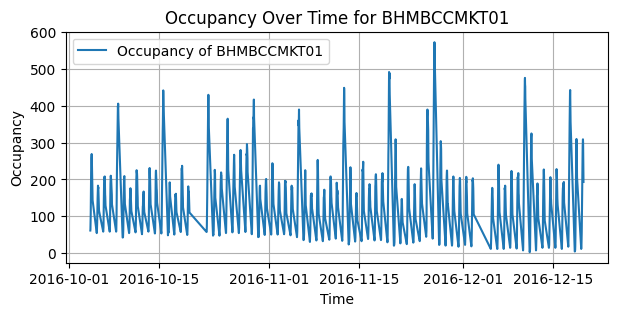

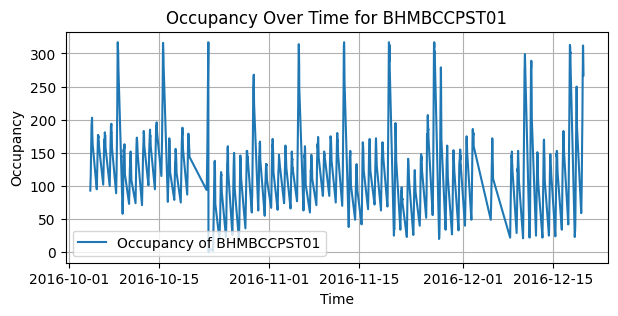

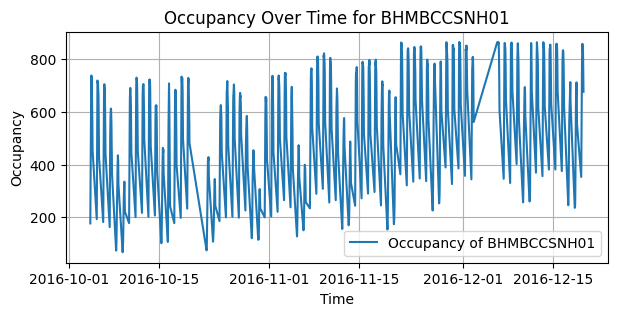

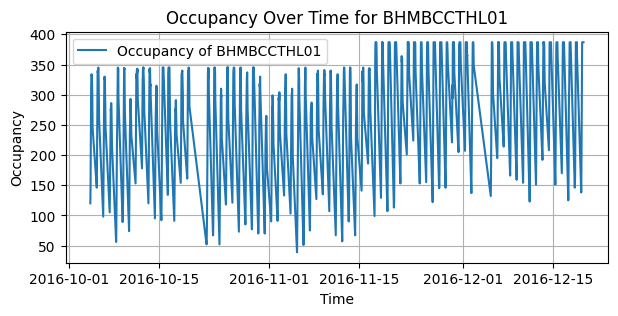

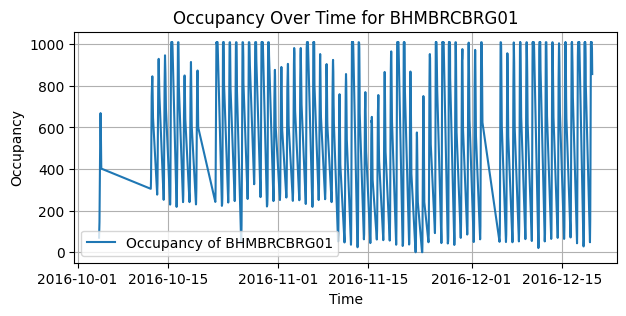

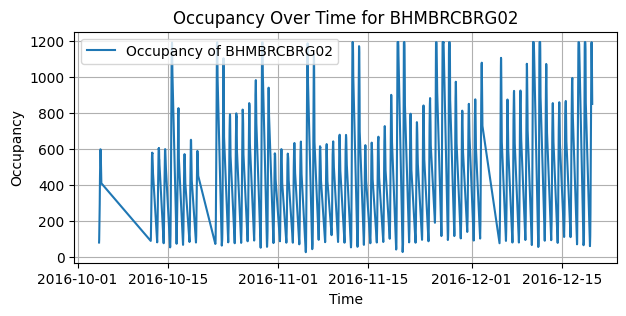

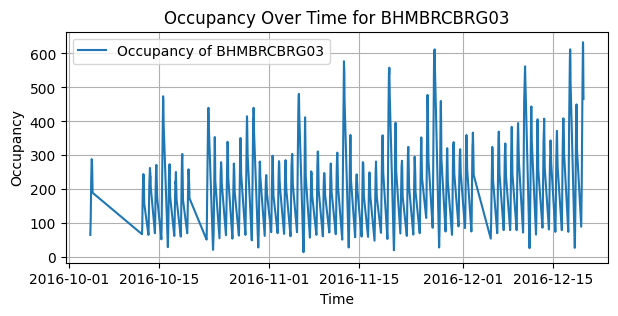

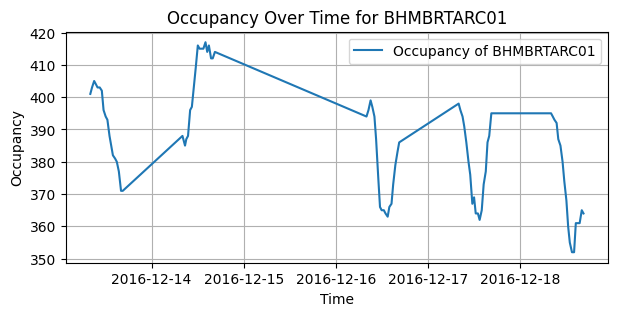

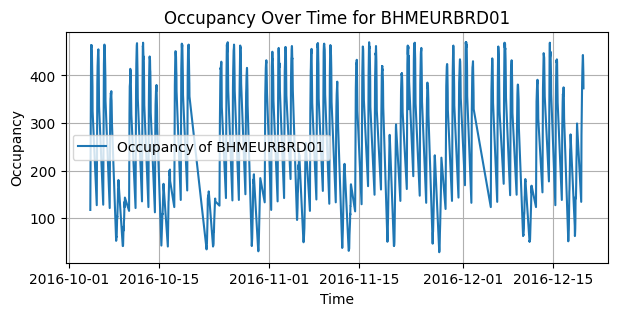

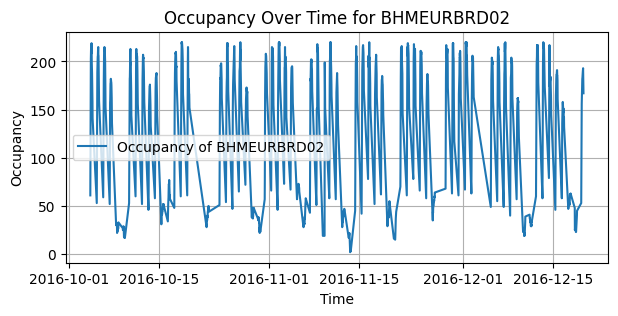

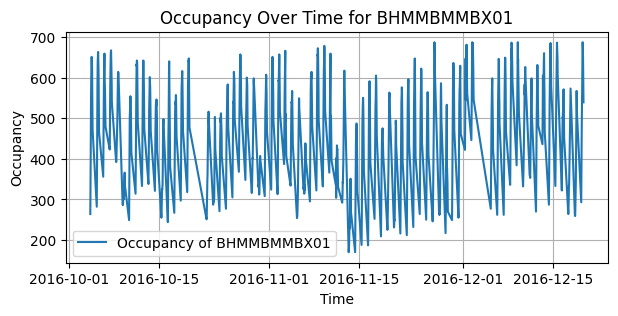

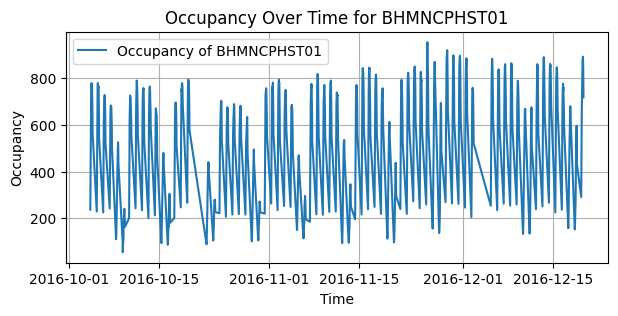

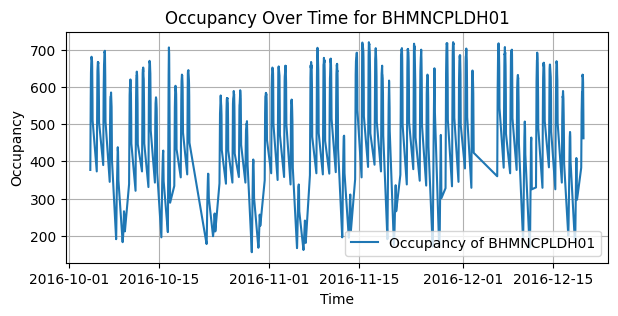

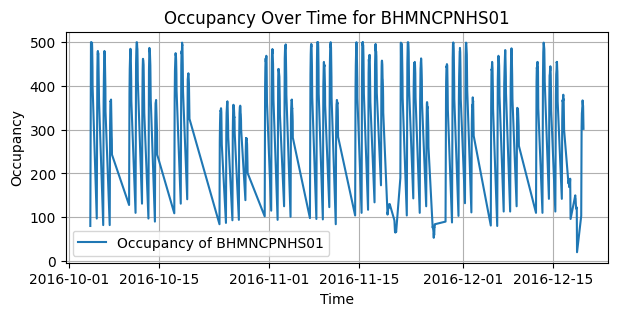

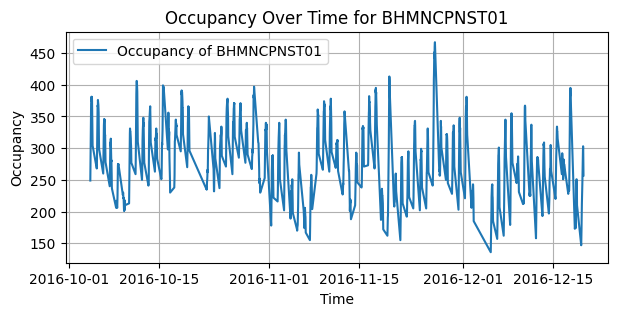

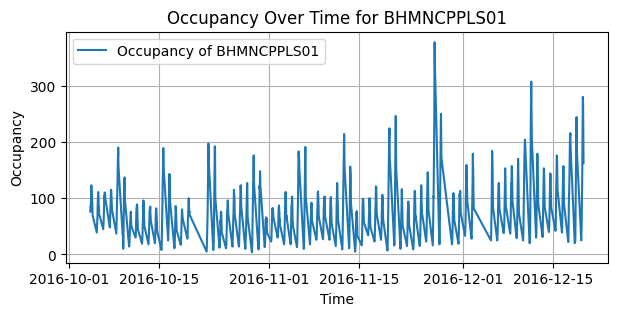

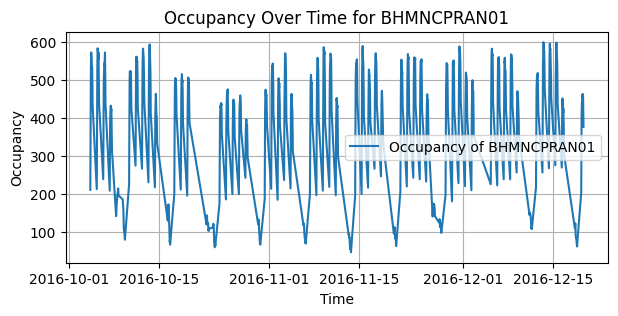

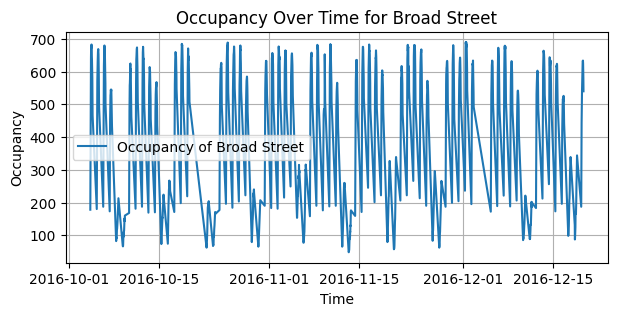

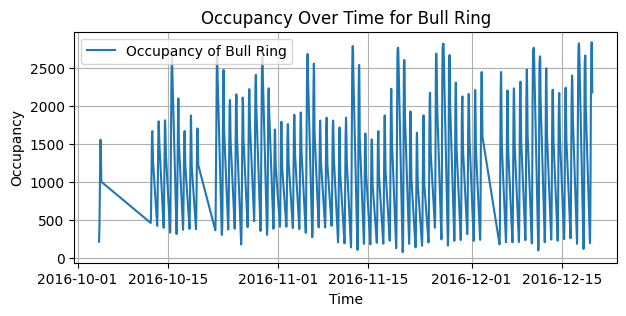

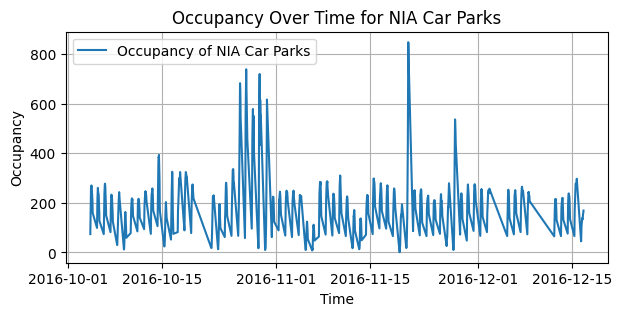

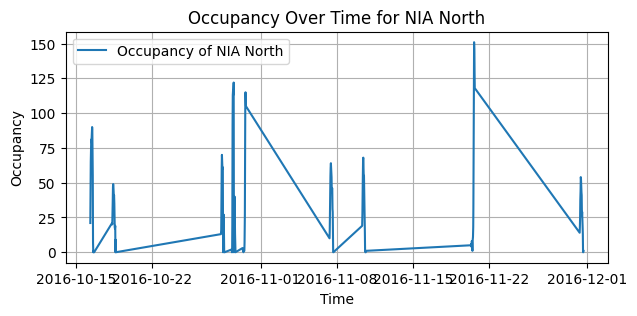

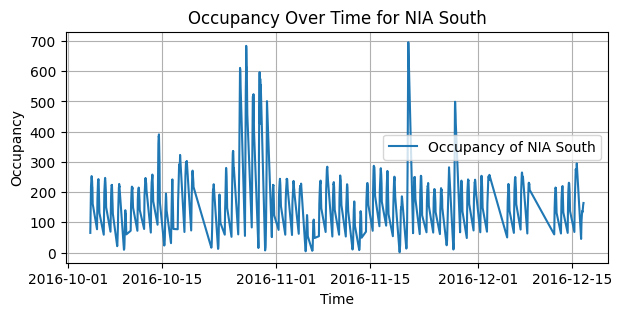

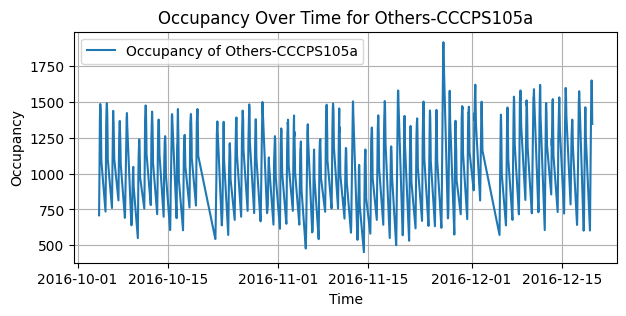

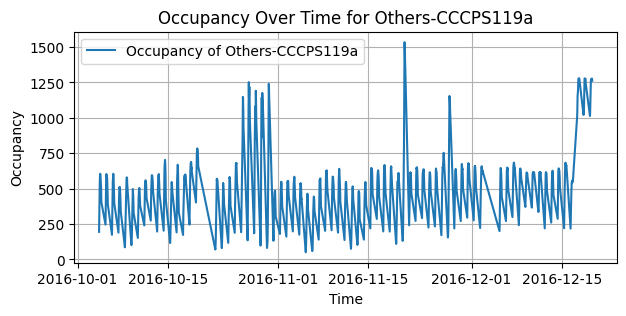

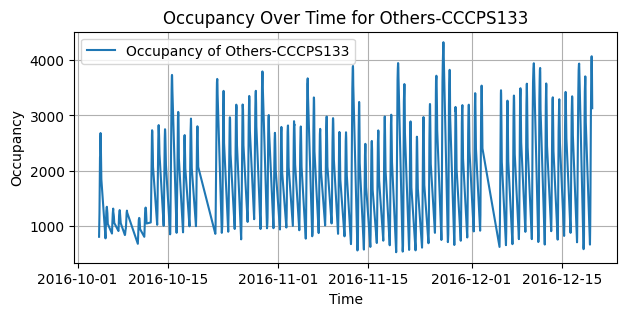

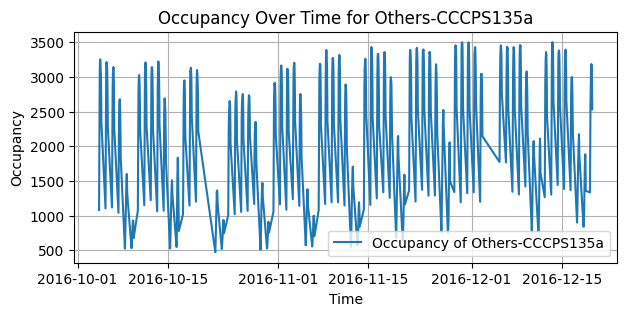

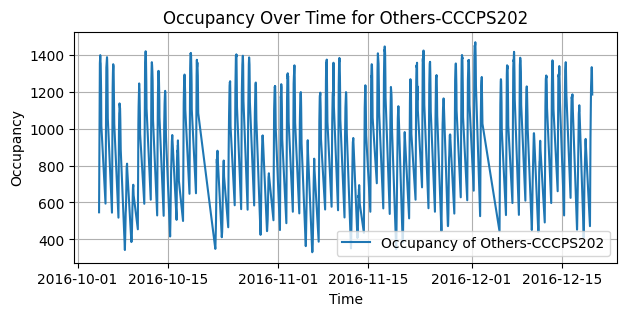

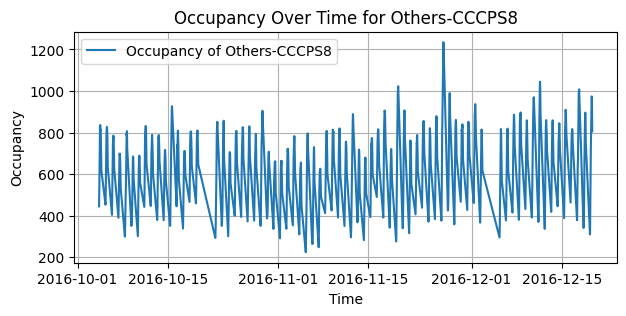

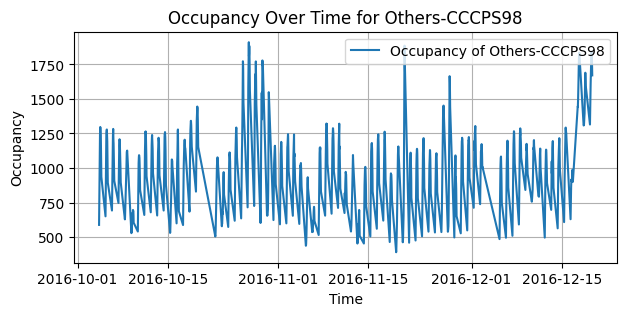

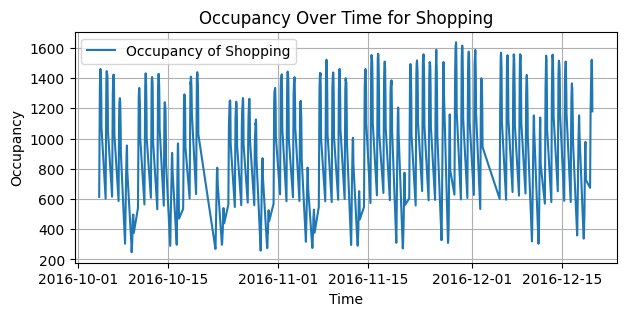

In [10]:
import matplotlib.pyplot as plt

parking_lots = df['SystemCodeNumber'].unique()

for lot in parking_lots:
    lot_data = df[df['SystemCodeNumber'] == lot]
    plt.figure(figsize=(7, 3))
    plt.plot(lot_data['LastUpdated'], lot_data['Occupancy'], label=f"Occupancy of {lot}")
    plt.xlabel('Time')
    plt.ylabel('Occupancy')
    plt.title(f'Occupancy Over Time for {lot}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
df_agg_dthh = df.groupby('date_time_halfhour').agg({'Occupancy':['sum','count'], 'Capacity':['sum','count']})
df_agg_dthh['PercentOccupied'] = df_agg_dthh.Occupancy['sum'] / df_agg_dthh.Capacity['sum']

# See what hours and dates does not have enough samples
df_agg_dthh[(df_agg_dthh.Occupancy['count']<20)|(df_agg_dthh.Capacity['sum']<25000)]

Occupancy       Capacity       PercentOccupied
                          sum count      sum count                
date_time_halfhour                                                
2016-10-28 08:00:00        10     1      450     1        0.022222
2016-12-13 13:30:00       663     1      720     1        0.920833

As we can see, not enough samples for 13:30 and 8:30. We can remove them to not confuse the model. Also remove Occupancy and Capacity columns. They are unnecessary

In [12]:
df_agg_dthh.drop(columns=['Occupancy', 'Capacity'], inplace=True)
df_agg_dthh.drop([pd.Timestamp('2016-10-28 08:00:00'), pd.Timestamp('2016-12-13 13:30:00')], inplace=True)
df_agg_dthh

PercentOccupied
                                   
date_time_halfhour                 
2016-10-04 08:00:00        0.201437
2016-10-04 08:30:00        0.247512
2016-10-04 09:00:00        0.315444
2016-10-04 09:30:00        0.382376
2016-10-04 10:00:00        0.438917
...                             ...
2016-12-19 14:30:00        0.762891
2016-12-19 15:00:00        0.746696
2016-12-19 15:30:00        0.718909
2016-12-19 16:00:00        0.667912
2016-12-19 16:30:00        0.619624

[1307 rows x 1 columns]

Let's find missing values

In [13]:
temp = df_agg_dthh.reset_index()
temp['date'] = temp.date_time_halfhour.dt.date
temp['time'] = temp.date_time_halfhour.dt.time
temp = temp.groupby('date').count()
temp = pd.DataFrame(temp, index=pd.date_range('2016-10-04', '2016-12-19')).fillna(0)
temp[temp.date_time_halfhour<18]

C:\Users\slayr\AppData\Local\Temp\ipykernel_12924\1386130871.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  temp = temp.groupby('date').count()


date_time_halfhour PercentOccupied  time
                                                   
2016-10-20                0.0             0.0   0.0
2016-10-21                0.0             0.0   0.0
2016-10-28               17.0            17.0  17.0
2016-10-30               16.0            16.0  16.0
2016-11-18               17.0            17.0  17.0
2016-11-25               17.0            17.0  17.0
2016-12-03                0.0             0.0   0.0
2016-12-04                0.0             0.0   0.0
2016-12-13               17.0            17.0  17.0
2016-12-14               17.0            17.0  17.0

Look at the graph below, we have missing values. Need to fill the gaps

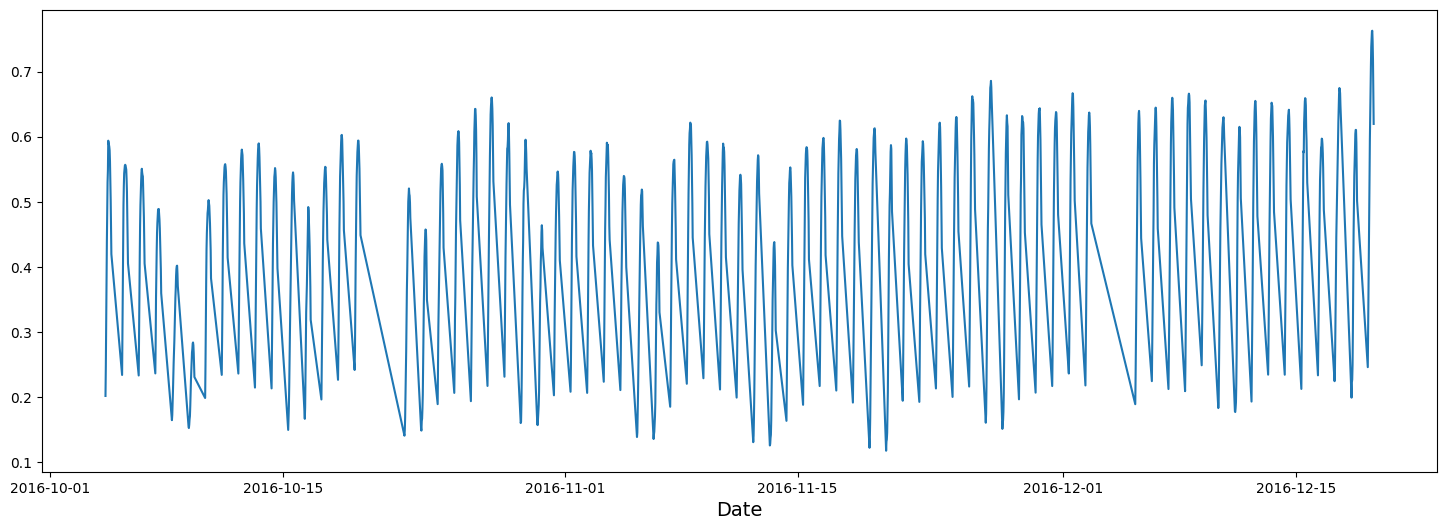

In [14]:
plt.figure(figsize=(18,6))
plt.plot(df_agg_dthh)
plt.xlabel('Date', fontsize=14);

Fill missing occupancy data by using the occupancy from the same time exactly one week earlier since we have the same occupany pattern everyday.

In [15]:
def fill_with_week_prior(df, column, year, month, day, hour, minutes):
  df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes)), column] = \
      df.loc[pd.to_datetime(datetime.datetime(year, month, day, hour, minutes) + datetime.timedelta(days=-7)), column].values[0]

df_agg_fillmissing = df_agg_dthh.copy()


for hour in range(8, 17):
  for half_hour in [0, 30]:
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 20, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 21, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 3, hour, half_hour)
    fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 4, hour, half_hour)

fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 30, 16, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 30, 16, 30)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 11, 18, 9, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 11, 25, 8, 30)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 14, 11, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 10, 28, 8, 0)
fill_with_week_prior(df_agg_fillmissing, 'PercentOccupied', 2016, 12, 13, 13, 30)

df_agg_fillmissing.sort_index(inplace=True)

Let's take another look to see that we don't have any more gaps in the data.

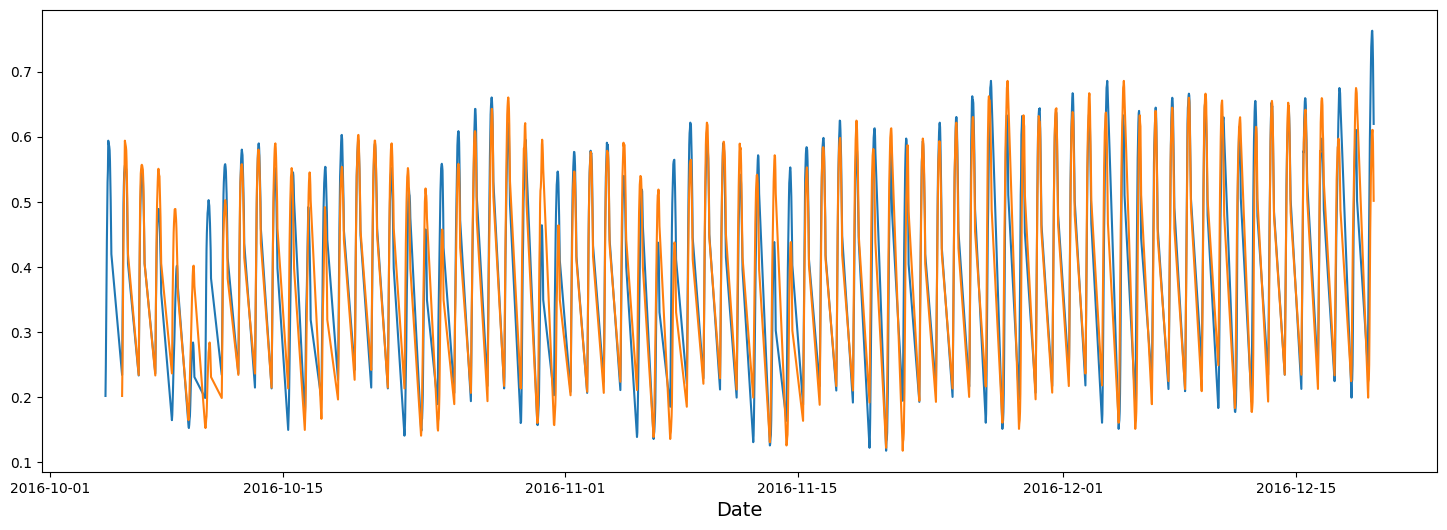

In [16]:
plt.figure(figsize=(18,6))
plt.plot(df_agg_fillmissing)
plt.plot(df_agg_fillmissing.shift(18))
plt.xlabel('Date', fontsize=14);

Lets create the model already, we will start by constructing test and train datasets

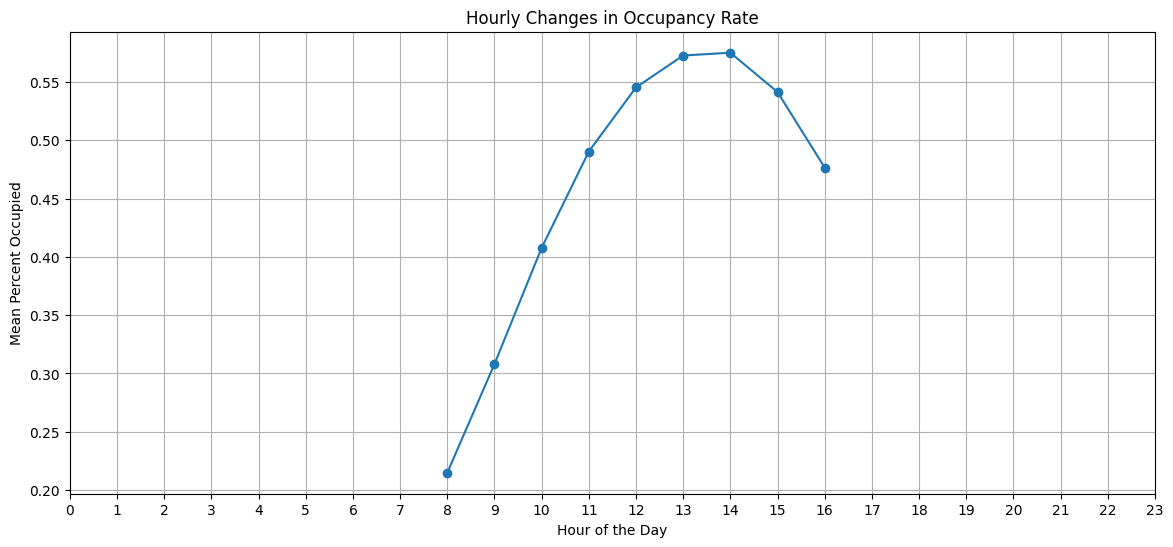

In [17]:
# Aggregate data by hour of the day
df_agg_hourly = df_agg_fillmissing.groupby(df_agg_fillmissing.index.hour).mean()

# Plot hourly changes in occupancy rate
plt.figure(figsize=(14, 6))
plt.plot(df_agg_hourly.index, df_agg_hourly['PercentOccupied'], marker='o', linestyle='-')
plt.title('Hourly Changes in Occupancy Rate')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Percent Occupied')
plt.xticks(range(24))
plt.grid(True)
plt.show()

In [18]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)


data_use = df_agg_fillmissing.reset_index()['PercentOccupied']

for train_index, test_index in tscv.split(data_use):
  train = data_use[train_index]
  test = data_use[test_index]

test.index = df_agg_fillmissing.index[len(train):]
train.index = df_agg_fillmissing.index[:len(train)]

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


# SARIMAX

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
my_seasonal_order = (1, 1, 1, 18)
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=my_seasonal_order)
results_SAR = sarima_model.fit(disp=-1)

C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Bring the graph

C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


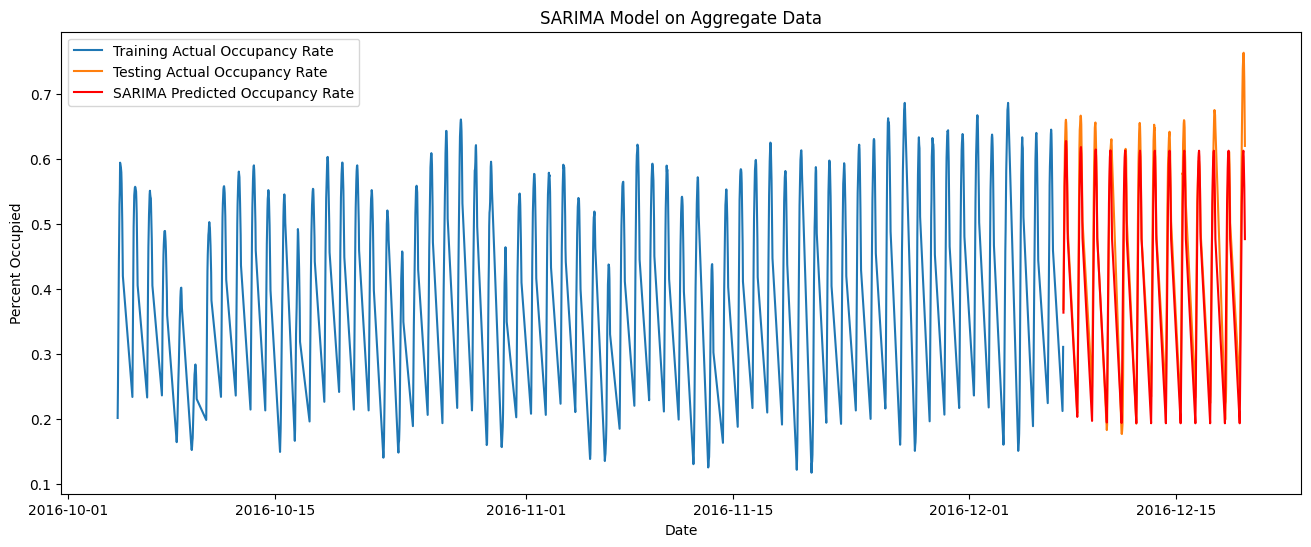

In [20]:
plt.figure(figsize=(16,6))
plt.title('SARIMA Model on Aggregate Data')
plt.plot(train, label='Training Actual Occupancy Rate')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
y_pred_sar = pd.Series(results_SAR.forecast(steps=len(test)).values, index=test.index)
plt.plot(test, label='Testing Actual Occupancy Rate')
plt.plot(y_pred_sar, color='red', label='SARIMA Predicted Occupancy Rate')
plt.legend()

plt.show()

Metrics

In [21]:
from sklearn import metrics
mae_sarimax = metrics.mean_absolute_error(test,y_pred_sar)

mae_sarimax
mse_sarimax = metrics.mean_squared_error(test, y_pred_sar)

As we can observe, this model performs super well. Let's move on other models to compare model performances.

# LSTM (Long Short Term Memory)

Construct datasets

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_agg_fillmissing[['PercentOccupied']])

def create_sequences(data, time_steps=18):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 18
X, y = create_sequences(scaled_data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build LSTM Model

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 18, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 - 3s - 82ms/step - loss: 0.0727 - val_loss: 0.0570
Epoch 2/20
35/35 - 0s - 8ms/step - loss: 0.0450 - val_loss: 0.0509
Epoch 3/20
35/35 - 0s - 8ms/step - loss: 0.0363 - val_loss: 0.0542
Epoch 4/20
35/35 - 0s - 8ms/step - loss: 0.0194 - val_loss: 0.0163
Epoch 5/20
35/35 - 0s - 8ms/step - loss: 0.0132 - val_loss: 0.0142
Epoch 6/20
35/35 - 0s - 8ms/step - loss: 0.0130 - val_loss: 0.0135
Epoch 7/20
35/35 - 0s - 8ms/step - loss: 0.0110 - val_loss: 0.0164
Epoch 8/20
35/35 - 0s - 8ms/step - loss: 0.0128 - val_loss: 0.0115
Epoch 9/20
35/35 - 0s - 8ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 10/20
35/35 - 0s - 8ms/step - loss: 0.0093 - val_loss: 0.0174
Epoch 11/20
35/35 - 0s - 8ms/step - loss: 0.0088 - val_loss: 0.0092
Epoch 12/20
35/35 - 0s - 8ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 13/20
35/35 - 0s - 8ms/step - loss: 0.0087 - val_loss: 0.0082
Epoch 14/20
35/35 - 0s - 8ms/step - loss: 0.0077 - val_loss: 0.0108
Epoch 15/20
35/35 - 0s - 8ms/step - loss: 0.0084 - val_l

Plot the results

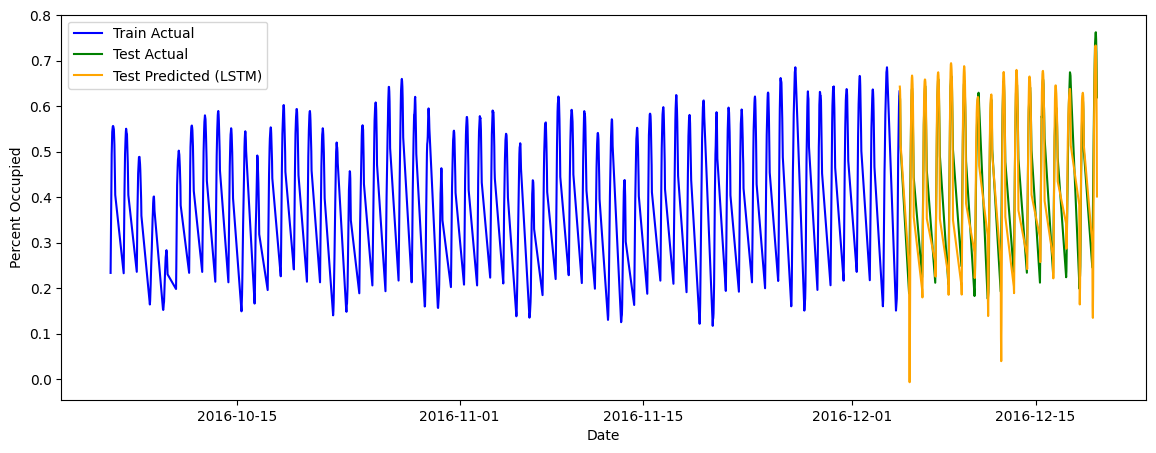

In [24]:
plt.figure(figsize=(14, 5))
plt.plot(df_agg_fillmissing.index[time_steps:train_size+time_steps], y_train_actual, color='blue', label='Train Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], y_test_actual, color='green', label='Test Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], test_predict, color='orange', label='Test Predicted (LSTM)')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.legend()
plt.show()

Metrics

In [25]:
mae_lstm = metrics.mean_absolute_error(test_predict,y_test_actual)
mae_lstm
mse_lstm = metrics.mean_squared_error(test_predict, y_test_actual)

Sir great sir 

# Convolutional Neural Networks (CNN)

In [26]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

X = X.reshape(X.shape[0], X.shape[1], 1)  # CNN expects 3D input

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_model.summary()

history_cnn = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

train_predict_cnn = cnn_model.predict(X_train)
test_predict_cnn = cnn_model.predict(X_test)

test_predict_cnn = scaler.inverse_transform(test_predict_cnn)

C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 17, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │          25,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,893 (101.14 KB)

 Trainable params: 25,893 (101.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 - 1s - 28ms/step - loss: 0.0803 - val_loss: 0.0405
Epoch 2/20
35/35 - 0s - 3ms/step - loss: 0.0254 - val_loss: 0.0162
Epoch 3/20
35/35 - 0s - 3ms/step - loss: 0.0141 - val_loss: 0.0145
Epoch 4/20
35/35 - 0s - 3ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 5/20
35/35 - 0s - 3ms/step - loss: 0.0104 - val_loss: 0.0094
Epoch 6/20
35/35 - 0s - 3ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 7/20
35/35 - 0s - 3ms/step - loss: 0.0086 - val_loss: 0.0080
Epoch 8/20
35/35 - 0s - 3ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 9/20
35/35 - 0s - 3ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 10/20
35/35 - 0s - 3ms/step - loss: 0.0066 - val_loss: 0.0084
Epoch 11/20
35/35 - 0s - 3ms/step - loss: 0.0063 - val_loss: 0.0085
Epoch 12/20
35/35 - 0s - 3ms/step - loss: 0.0059 - val_loss: 0.0070
Epoch 13/20
35/35 - 0s - 3ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 14/20
35/35 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 15/20
35/35 - 0s - 3ms/step - loss: 0.0048 - val_l

Plot the results

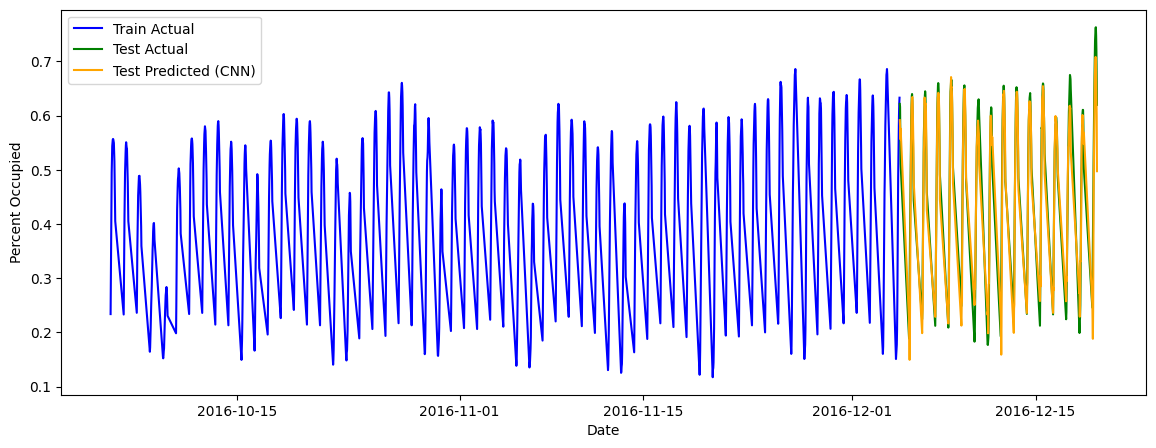

In [27]:
plt.figure(figsize=(14, 5))
plt.plot(df_agg_fillmissing.index[time_steps:train_size+time_steps], y_train_actual, color='blue', label='Train Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], y_test_actual, color='green', label='Test Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], test_predict_cnn, color='orange', label='Test Predicted (CNN)')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.legend()
plt.show()

Metrics

In [28]:
mae_cnn = metrics.mean_absolute_error(test_predict_cnn,y_test_actual)
mae_cnn
mse_cnn = metrics.mean_squared_error(test_predict_cnn, y_test_actual)

# Feedforward Neural Network (Fully Connected Network)

C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 - 1s - 29ms/step - loss: 0.0370 - val_loss: 0.0134
Epoch 2/20
35/35 - 0s - 2ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 3/20
35/35 - 0s - 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 4/20
35/35 - 0s - 2ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 5/20
35/35 - 0s - 2ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 6/20
35/35 - 0s - 3ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 7/20
35/35 - 0s - 3ms/step - loss: 0.0047 - val_loss: 0.0051
Epoch 8/20
35/35 - 0s - 2ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 9/20
35/35 - 0s - 2ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 10/20
35/35 - 0s - 2ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 11/20
35/35 - 0s - 2ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 12/20
35/35 - 0s - 2ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 13/20
35/35 - 0s - 2ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 14/20
35/35 - 0s - 3ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 15/20
35/35 - 0s - 2ms/step - loss: 0.0029 - val_l

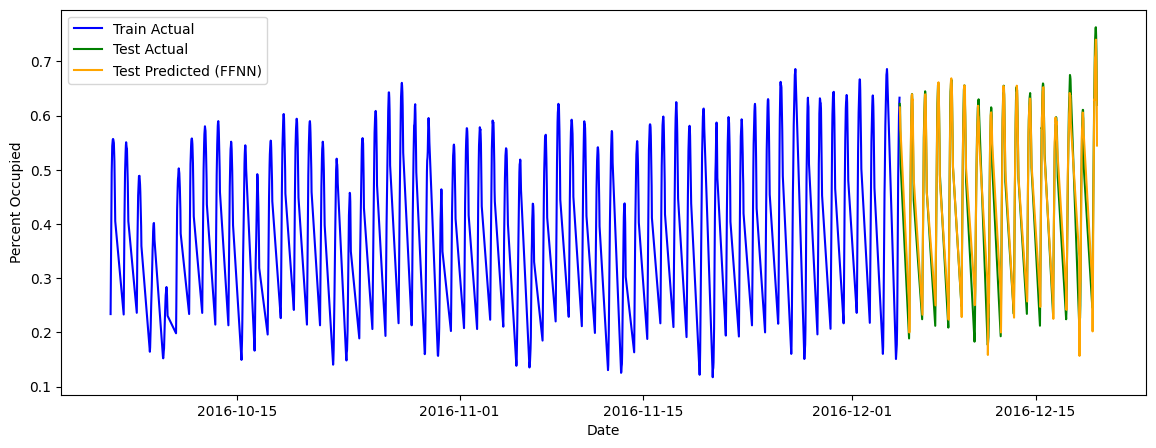

In [29]:
X_flat = X.reshape(X.shape[0], X.shape[1])

ffnn_model = Sequential()
ffnn_model.add(Dense(64, activation='relu', input_shape=(time_steps,)))
ffnn_model.add(Dense(32, activation='relu'))
ffnn_model.add(Dense(1))

ffnn_model.compile(optimizer='adam', loss='mean_squared_error')
ffnn_model.summary()

history_ffnn = ffnn_model.fit(X_train.reshape(X_train.shape[0], time_steps), y_train, epochs=20, batch_size=32, validation_data=(X_test.reshape(X_test.shape[0], time_steps), y_test), verbose=2)

train_predict_ffnn = ffnn_model.predict(X_train.reshape(X_train.shape[0], time_steps))
test_predict_ffnn = ffnn_model.predict(X_test.reshape(X_test.shape[0], time_steps))

test_predict_ffnn = scaler.inverse_transform(test_predict_ffnn)

plt.figure(figsize=(14, 5))
plt.plot(df_agg_fillmissing.index[time_steps:train_size+time_steps], y_train_actual, color='blue', label='Train Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], y_test_actual, color='green', label='Test Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], test_predict_ffnn, color='orange', label='Test Predicted (FFNN)')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.legend()
plt.show()

Metrics

In [30]:
mae_ffnn = metrics.mean_absolute_error(test_predict_ffnn, y_test_actual)
mae_ffnn
mse_ffnn = metrics.mean_squared_error(test_predict_ffnn, y_test_actual)

# XGBoost

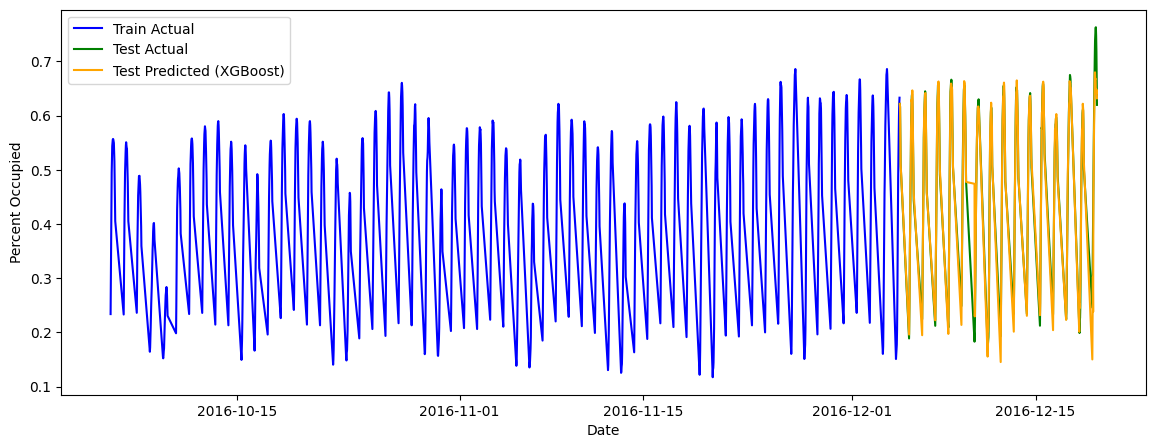

In [31]:
import xgboost as xgb

def create_sequences_xgb(data, time_steps=18):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

X_xgb, y_xgb = create_sequences_xgb(scaled_data, time_steps)

train_size_xgb = int(len(X_xgb) * 0.8)
X_train_xgb, X_test_xgb = X_xgb[:train_size_xgb], X_xgb[train_size_xgb:]
y_train_xgb, y_test_xgb = y_xgb[:train_size_xgb], y_xgb[train_size_xgb:]

train_dmatrix = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
test_dmatrix = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

xgb_model = xgb.train(params, train_dmatrix, num_boost_round=100)

test_predict_xgb = xgb_model.predict(test_dmatrix)

test_predict_xgb = scaler.inverse_transform(test_predict_xgb.reshape(-1, 1))
y_train_actual_xgb = scaler.inverse_transform(y_train_xgb.reshape(-1, 1))
y_test_actual_xgb = scaler.inverse_transform(y_test_xgb.reshape(-1, 1))

plt.figure(figsize=(14, 5))
plt.plot(df_agg_fillmissing.index[time_steps:train_size+time_steps], y_train_actual, color='blue', label='Train Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], y_test_actual, color='green', label='Test Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], test_predict_xgb, color='orange', label='Test Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.legend()
plt.show()





In [32]:
mae_xgboost = metrics.mean_absolute_error(test_predict_xgb, y_test_actual)
mae_xgboost
mse_xgboost = metrics.mean_squared_error(test_predict_xgb, y_test_actual)

# CatBoost

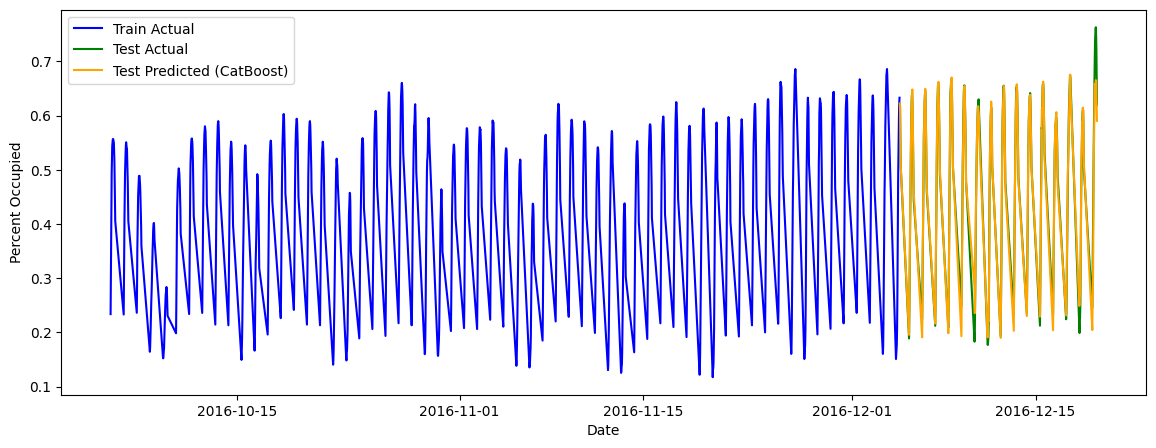

In [33]:
from catboost import CatBoostRegressor

def create_sequences_catboost(data, time_steps=18):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

X_cat, y_cat = create_sequences_catboost(scaled_data, time_steps)

train_size_cat = int(len(X_cat) * 0.8)
X_train_cat, X_test_cat = X_cat[:train_size_cat], X_cat[train_size_cat:]
y_train_cat, y_test_cat = y_cat[:train_size_cat], y_cat[train_size_cat:]

cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0)

cat_model.fit(X_train_cat, y_train_cat)

test_predict_cat = cat_model.predict(X_test_cat)

test_predict_cat = scaler.inverse_transform(test_predict_cat.reshape(-1, 1))
y_train_actual_cat = scaler.inverse_transform(y_train_cat.reshape(-1, 1))
y_test_actual_cat = scaler.inverse_transform(y_test_cat.reshape(-1, 1))

plt.figure(figsize=(14, 5))
plt.plot(df_agg_fillmissing.index[time_steps:train_size+time_steps], y_train_actual, color='blue', label='Train Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], y_test_actual, color='green', label='Test Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], test_predict_cat, color='orange', label='Test Predicted (CatBoost)')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.legend()
plt.show()




In [34]:
mae_catboost = metrics.mean_absolute_error(test_predict_cat, y_test_actual_cat)
mae_catboost
mse_catboost = metrics.mean_squared_error(test_predict_cat, y_test_actual_cat)

# Extra Trees

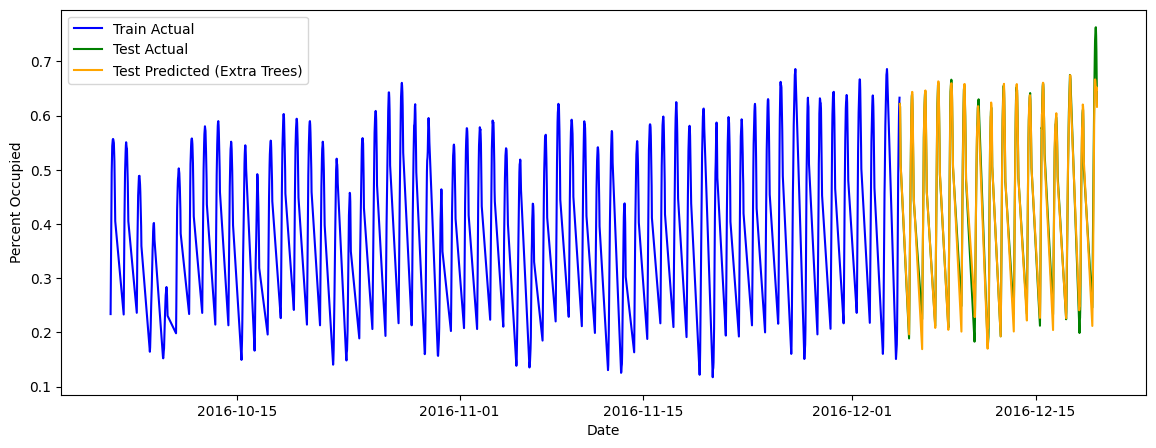

In [35]:
from sklearn.ensemble import ExtraTreesRegressor

def create_sequences_extratrees(data, time_steps=18):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

X_et, y_et = create_sequences_extratrees(scaled_data, time_steps)

# Split into train and test sets
train_size_et = int(len(X_et) * 0.8)
X_train_et, X_test_et = X_et[:train_size_et], X_et[train_size_et:]
y_train_et, y_test_et = y_et[:train_size_et], y_et[train_size_et:]

# Build the Extra Trees model
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# Train the model
et_model.fit(X_train_et, y_train_et)

test_predict_et = et_model.predict(X_test_et)

test_predict_et = scaler.inverse_transform(test_predict_et.reshape(-1, 1))
y_train_actual_et = scaler.inverse_transform(y_train_et.reshape(-1, 1))
y_test_actual_et = scaler.inverse_transform(y_test_et.reshape(-1, 1))

# Plot the results for Extra Trees
plt.figure(figsize=(14, 5))
plt.plot(df_agg_fillmissing.index[time_steps:train_size+time_steps], y_train_actual, color='blue', label='Train Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], y_test_actual, color='green', label='Test Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], test_predict_et, color='orange', label='Test Predicted (Extra Trees)')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.legend()
plt.show()




In [36]:
# Metrics
mae_extra = metrics.mean_absolute_error(test_predict_et, y_test_actual_et)
mae_extra
mse_extra = metrics.mean_squared_error(test_predict_et, y_test_actual_et)

# GRU

C:\Users\slayr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 18, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
35/35 - 4s - 116ms/step - loss: 0.0681 - val_loss: 0.0405
Epoch 2/20
35/35 - 0s - 10ms/step - loss: 0.0278 - val_loss: 0.0291
Epoch 3/20
35/35 - 0s - 10ms/step - loss: 0.0205 - val_loss: 0.0200
Epoch 4/20
35/35 - 0s - 10ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 5/20
35/35 - 0s - 11ms/step - loss: 0.0113 - val_loss: 0.0162
Epoch 6/20
35/35 - 0s - 10ms/step - loss: 0.0109 - val_loss: 0.0123
Epoch 7/20
35/35 - 0s - 10ms/step - loss: 0.0106 - val_loss: 0.0143
Epoch 8/20
35/35 - 0s - 11ms/step - loss: 0.0104 - val_loss: 0.0112
Epoch 9/20
35/35 - 0s - 10ms/step - loss: 0.0099 - val_loss: 0.0112
Epoch 10/20
35/35 - 0s - 11ms/step - loss: 0.0097 - val_loss: 0.0109
Epoch 11/20
35/35 - 0s - 11ms/step - loss: 0.0094 - val_loss: 0.0109
Epoch 12/20
35/35 - 0s - 10ms/step - loss: 0.0095 - val_loss: 0.0122
Epoch 13/20
35/35 - 0s - 12ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 14/20
35/35 - 0s - 11ms/step - loss: 0.0091 - val_loss: 0.0115
Epoch 15/20
35/35 - 0s - 11ms/step - loss:

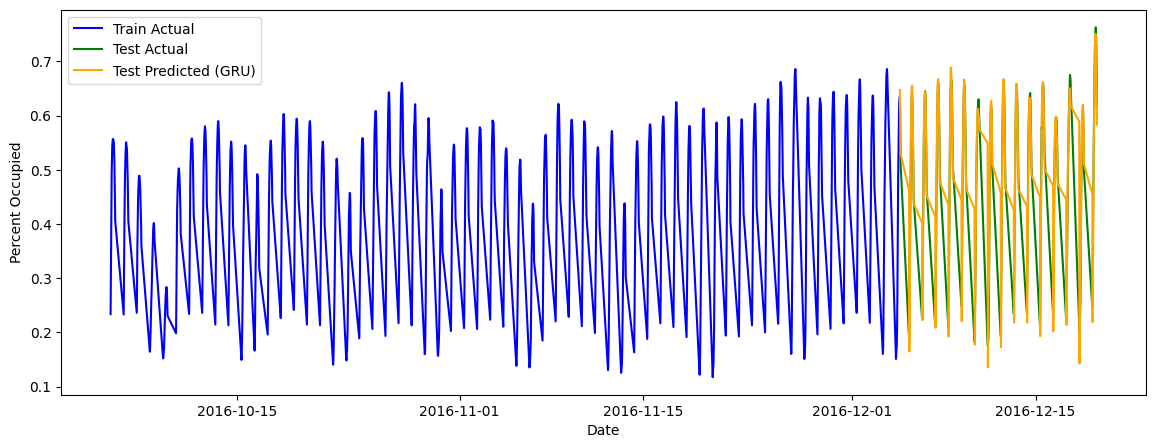

In [37]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def create_sequences(data, time_steps=18):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 18
X, y = create_sequences(scaled_data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for GRU

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(time_steps, 1)))
gru_model.add(GRU(units=50))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.summary()

history_gru = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2)

test_predict_gru = gru_model.predict(X_test)

test_predict_gru = scaler.inverse_transform(test_predict_gru)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(14, 5))
plt.plot(df_agg_fillmissing.index[time_steps:train_size+time_steps], y_train_actual, color='blue', label='Train Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], y_test_actual, color='green', label='Test Actual')
plt.plot(df_agg_fillmissing.index[train_size+time_steps:], test_predict_gru, color='orange', label='Test Predicted (GRU)')
plt.xlabel('Date')
plt.ylabel('Percent Occupied')
plt.legend()
plt.show()




In [38]:
mae_gru = metrics.mean_absolute_error(test_predict_gru, y_test_actual)

mae_gru
mse_gru = metrics.mean_squared_error(test_predict_gru, y_test_actual)

# Errors of all methods

Now that we tried 8 different models to solve our forecast problem, we want to see which model did the best job.

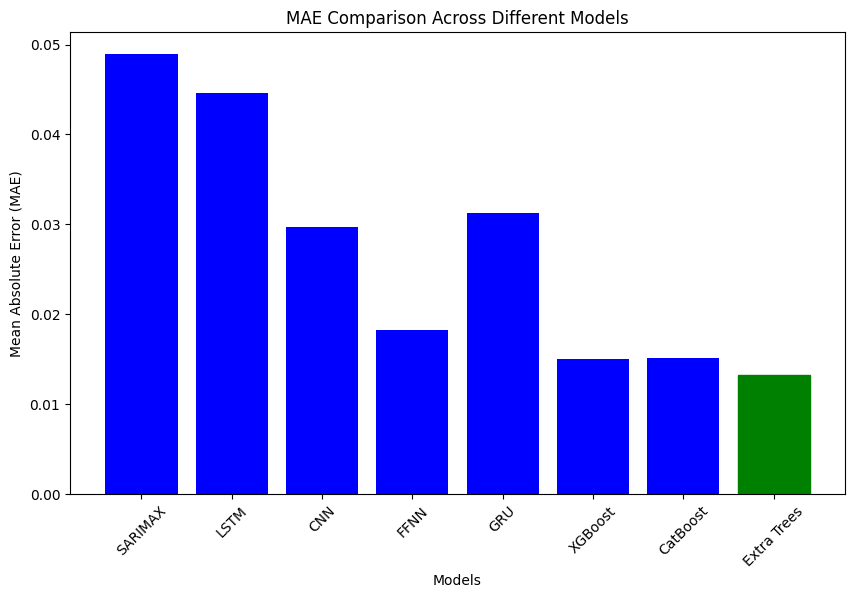

In [39]:
import matplotlib.pyplot as plt

mae_measurements = {
    'SARIMAX': mae_sarimax,
    'LSTM': mae_lstm,
    'CNN': mae_cnn,
    'FFNN': mae_ffnn,
    'GRU': mae_gru,
    'XGBoost': mae_xgboost,
    'CatBoost': mae_catboost,
    'Extra Trees': mae_extra
    # Add other models as needed
}

best_model = min(mae_measurements, key=mae_measurements.get)

plt.figure(figsize=(10, 6))
bars = plt.bar(mae_measurements.keys(), mae_measurements.values(), color='blue')

bars[list(mae_measurements.keys()).index(best_model)].set_color('green')

plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Comparison Across Different Models')
plt.xticks(rotation=45)
plt.show()


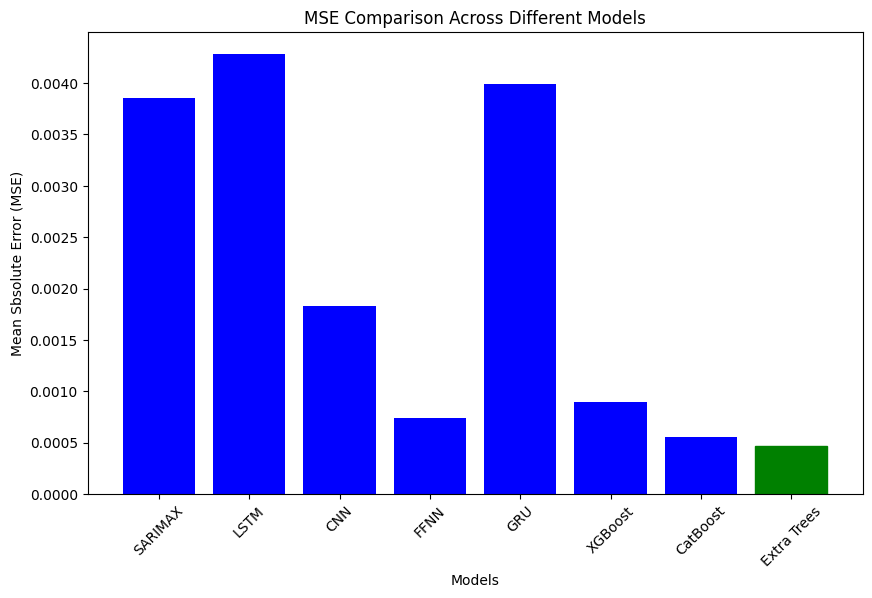

In [40]:
import matplotlib.pyplot as plt

mse_measurements = {
    'SARIMAX': mse_sarimax,
    'LSTM': mse_lstm,
    'CNN': mse_cnn,
    'FFNN': mse_ffnn,
    'GRU': mse_gru,
    'XGBoost': mse_xgboost,
    'CatBoost': mse_catboost,
    'Extra Trees': mse_extra
    # Add other models as needed
}

best_model = min(mse_measurements, key=mse_measurements.get)

plt.figure(figsize=(10, 6))
bars = plt.bar(mse_measurements.keys(), mse_measurements.values(), color='blue')

bars[list(mse_measurements.keys()).index(best_model)].set_color('green')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE Comparison Across Different Models')
plt.xticks(rotation=45)
plt.show()